In [64]:
import pandas as pd
import numpy as np

In [98]:
data = pd.read_csv('clean_test.csv')
data = data.iloc[:,1:]
data['datadate'] = pd.to_datetime(data.datadate,format = '%Y-%m-%d')
data = data.sort_values(by=['tic','datadate']).reset_index(drop=True)


In [99]:
# if text contains white space, pls uncomment below and run again.
# data = data[data.text!='']
# data = data[data.text!=' ']
# data = data[data.text!='  ']
data.shape

(253267, 12)

In [80]:
poword=pd.read_excel('LoughranMcDonald_SentimentWordLists_2018.xlsx',sheet_name=1,header=None)
neword=pd.read_excel('LoughranMcDonald_SentimentWordLists_2018.xlsx',sheet_name=2,header=None)

In [81]:
pword = poword.iloc[:,0].values.tolist()
nword = neword.iloc[:,0].values.tolist()

In [83]:
len(pword)

2355

In [84]:
with open('positive-words.txt') as fil:
    word = fil.readlines()
pword2 = [i.strip() for i in word]
pword2 = pword2[30:]
pword.extend(pword2)

with open('negative-words.txt',encoding = "iso-8859-1") as fil:
    word = fil.readlines()
nword2 = [i.strip() for i in word]
nword2 = nword2[31:]
nword.extend(nword2)

In [85]:
len(pword)

4361

In [87]:
import time

In [89]:
from collections import Counter

def get_word_frq_and_len(text):
    text_lst = text.split()
    return Counter(text_lst),len(text_lst)

def get_word_npratio_df(text_series, pword, nword):
    
    ratio_lst = []
    idx = 0
    start = time.time()
    for text in text_series:
        text_dic,total_len = get_word_frq_and_len(text)
        if total_len != 0:
            pw_count = 0
            nw_count = 0
            for key in text_dic.keys():
                if key in nword:
                    nw_count += text_dic[key]
                elif key in pword:
                    pw_count += text_dic[key]
            ratio_lst.append([nw_count/total_len, pw_count/total_len])
        else:
            ratio_lst.append(['',''])
        if idx%100000 ==0:
            end = time.time()
            print((end-start)/60,'min, 100000 done')
        idx+=1
    return ratio_lst

In [90]:
npratio = get_word_npratio_df(data.text,pword,nword)

8.093118667602539e-05 min, 100000 done
11.061360430717468 min, 100000 done
22.01753889322281 min, 100000 done


In [91]:
npratio_df = pd.DataFrame(npratio,columns=['nwratio','pwratio'])
npratio_df['p-n'] = npratio_df.pwratio.sub(npratio_df.nwratio)
npratio_df.head()

,nwratio,pwratio,p-n
0,0.027027,0.054054,0.027027
1,0.011765,0.047059,0.035294
2,0.016129,0.053763,0.037634
3,0.016216,0.054054,0.037838
4,0.026596,0.063830,0.037234


In [93]:
new_df = pd.concat([data.loc[:,['datadate','tic','cshoc', 'cshtrd', 'eps', 'prccd',
                                '3_day_change','retweets', 'replies', 'likes','is_retweet']],
                   npratio_df],axis = 1)

In [ ]:
final = new_df.loc[:,['nwratio','pwratio', 'p-n','3_day_change']]

final.to_csv('sentiment_result_test.csv')

In [ ]:
# the feature handling end here.
# if only need feature, may stop
# below is some EDA
# aim is to explore the relationship between only sentiment feature and other basic information

In [46]:
import matplotlib.pylab as plt
import seaborn as sns

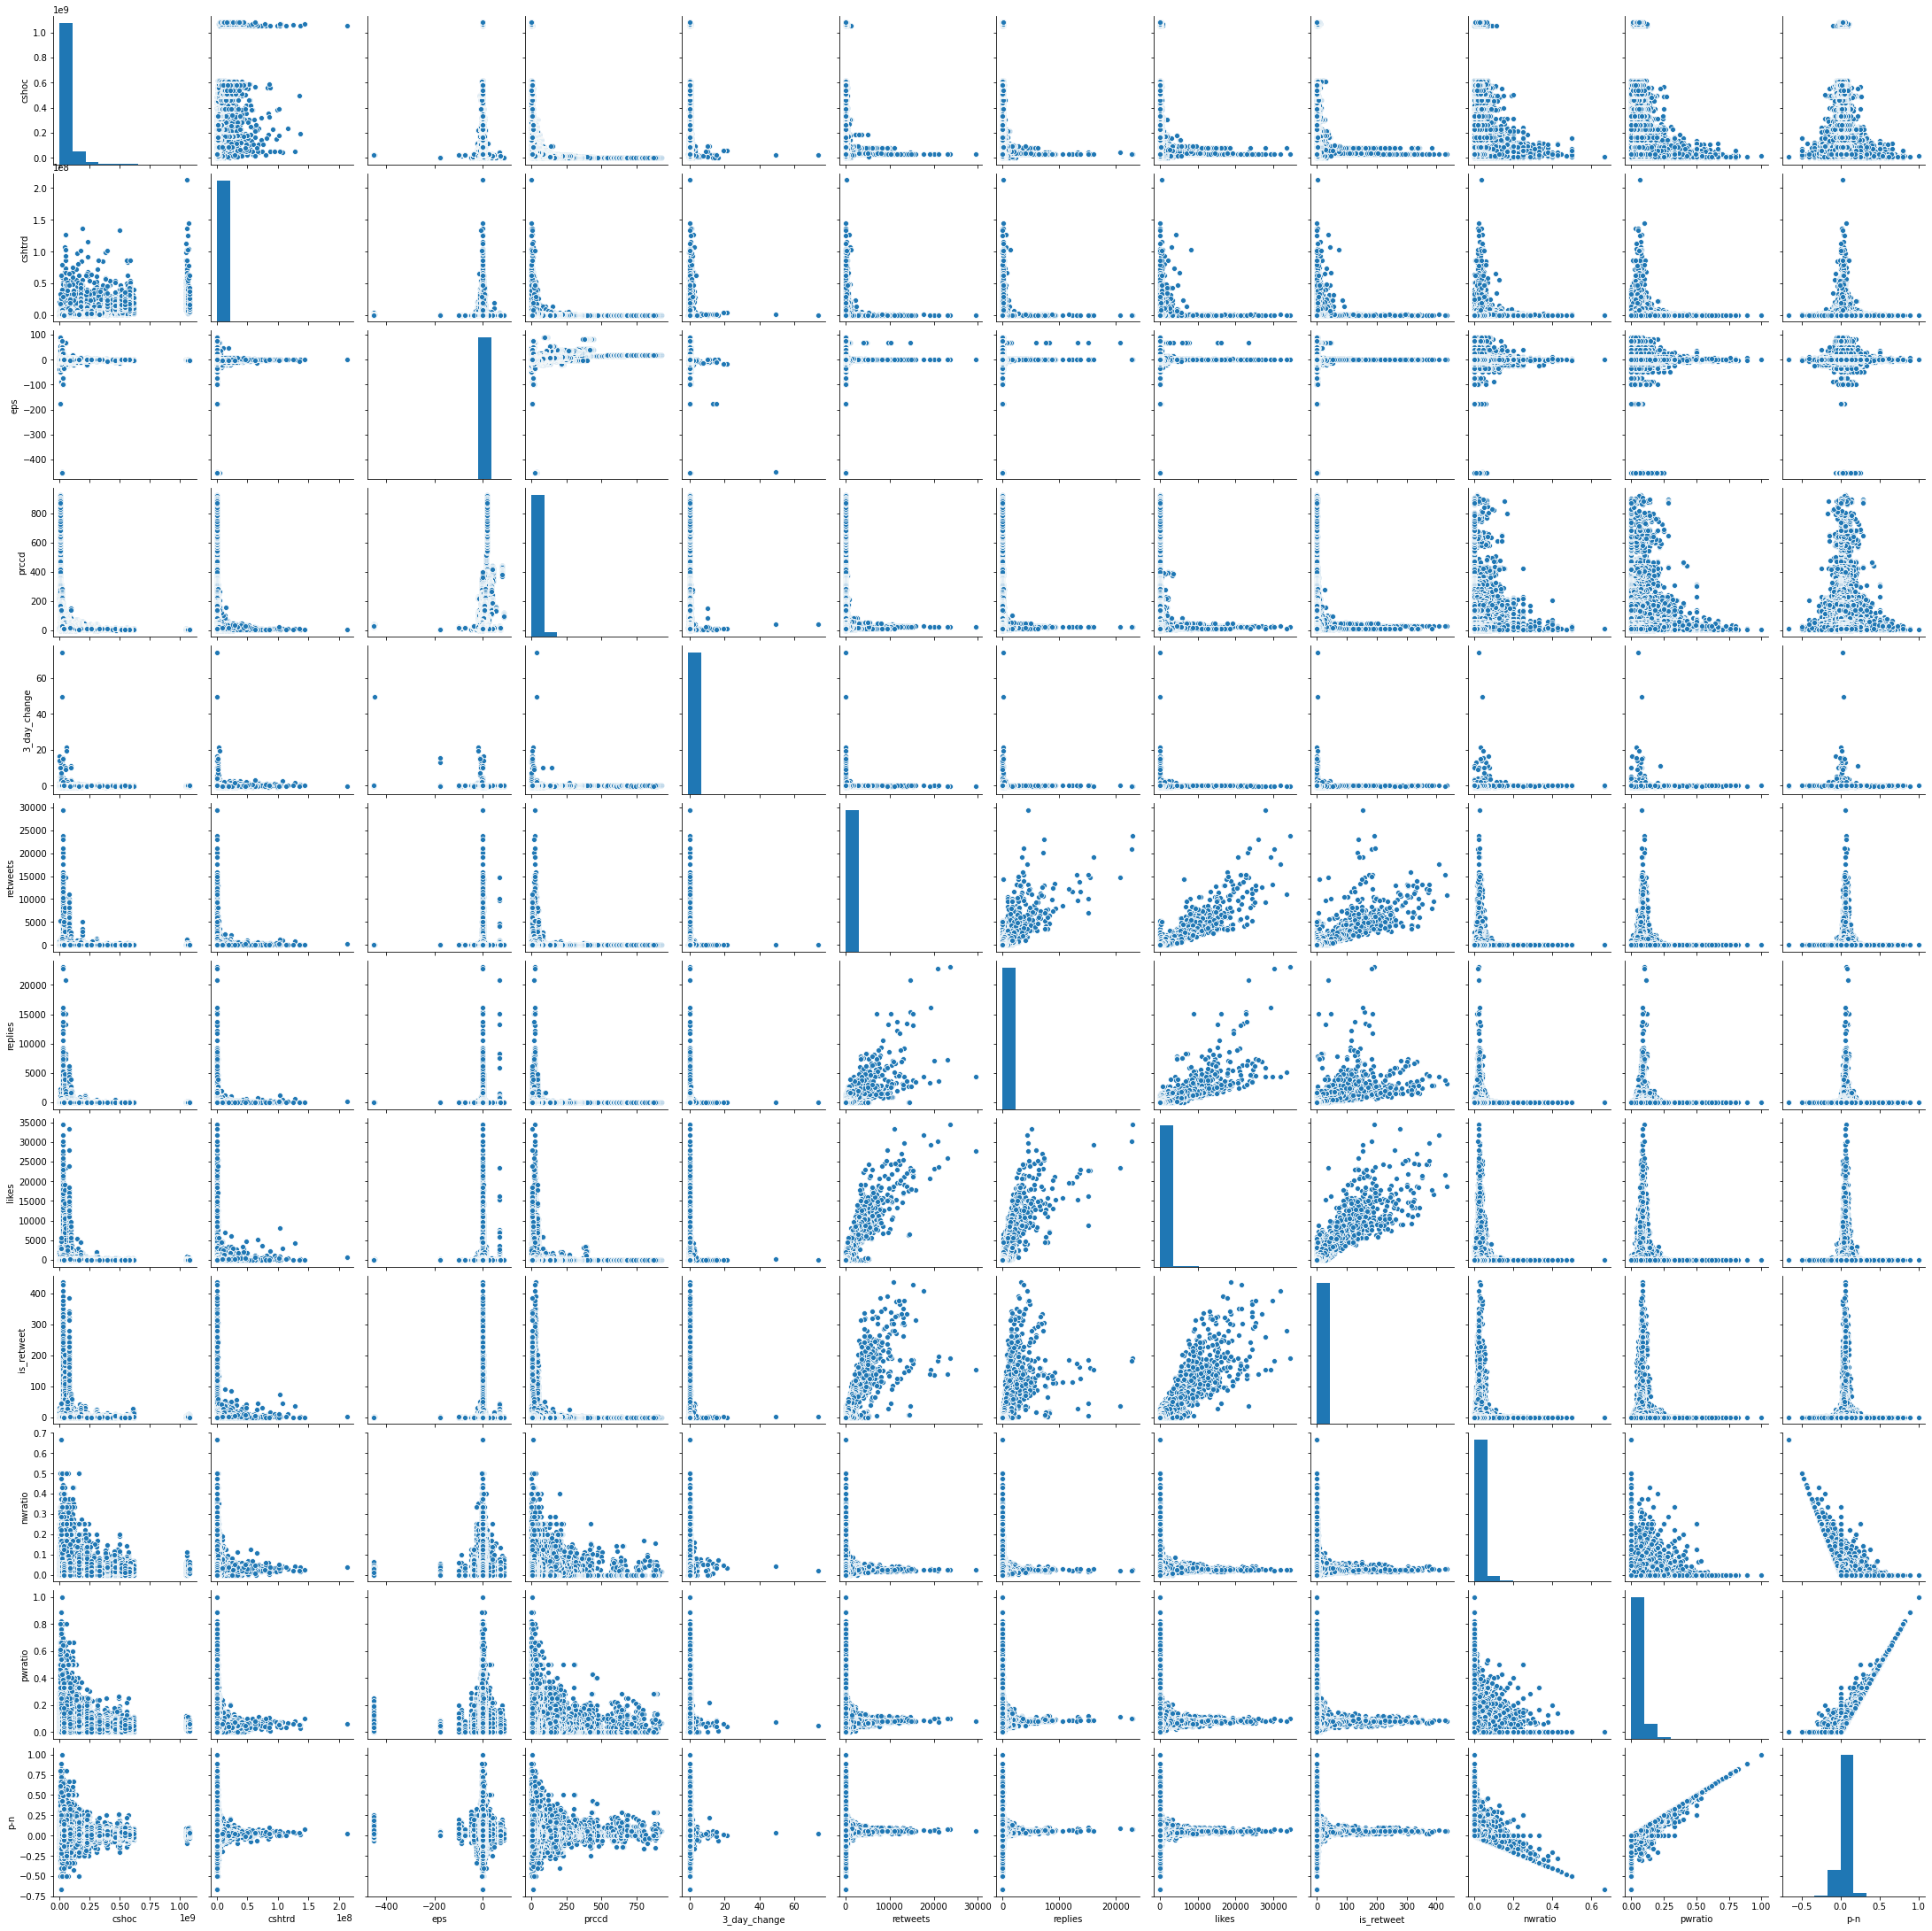

In [114]:
sns.pairplot(new_df)

In [19]:
new_df2 = new_df[new_df.loc[:,'3_day_change']>0.2].reset_index(drop=True)

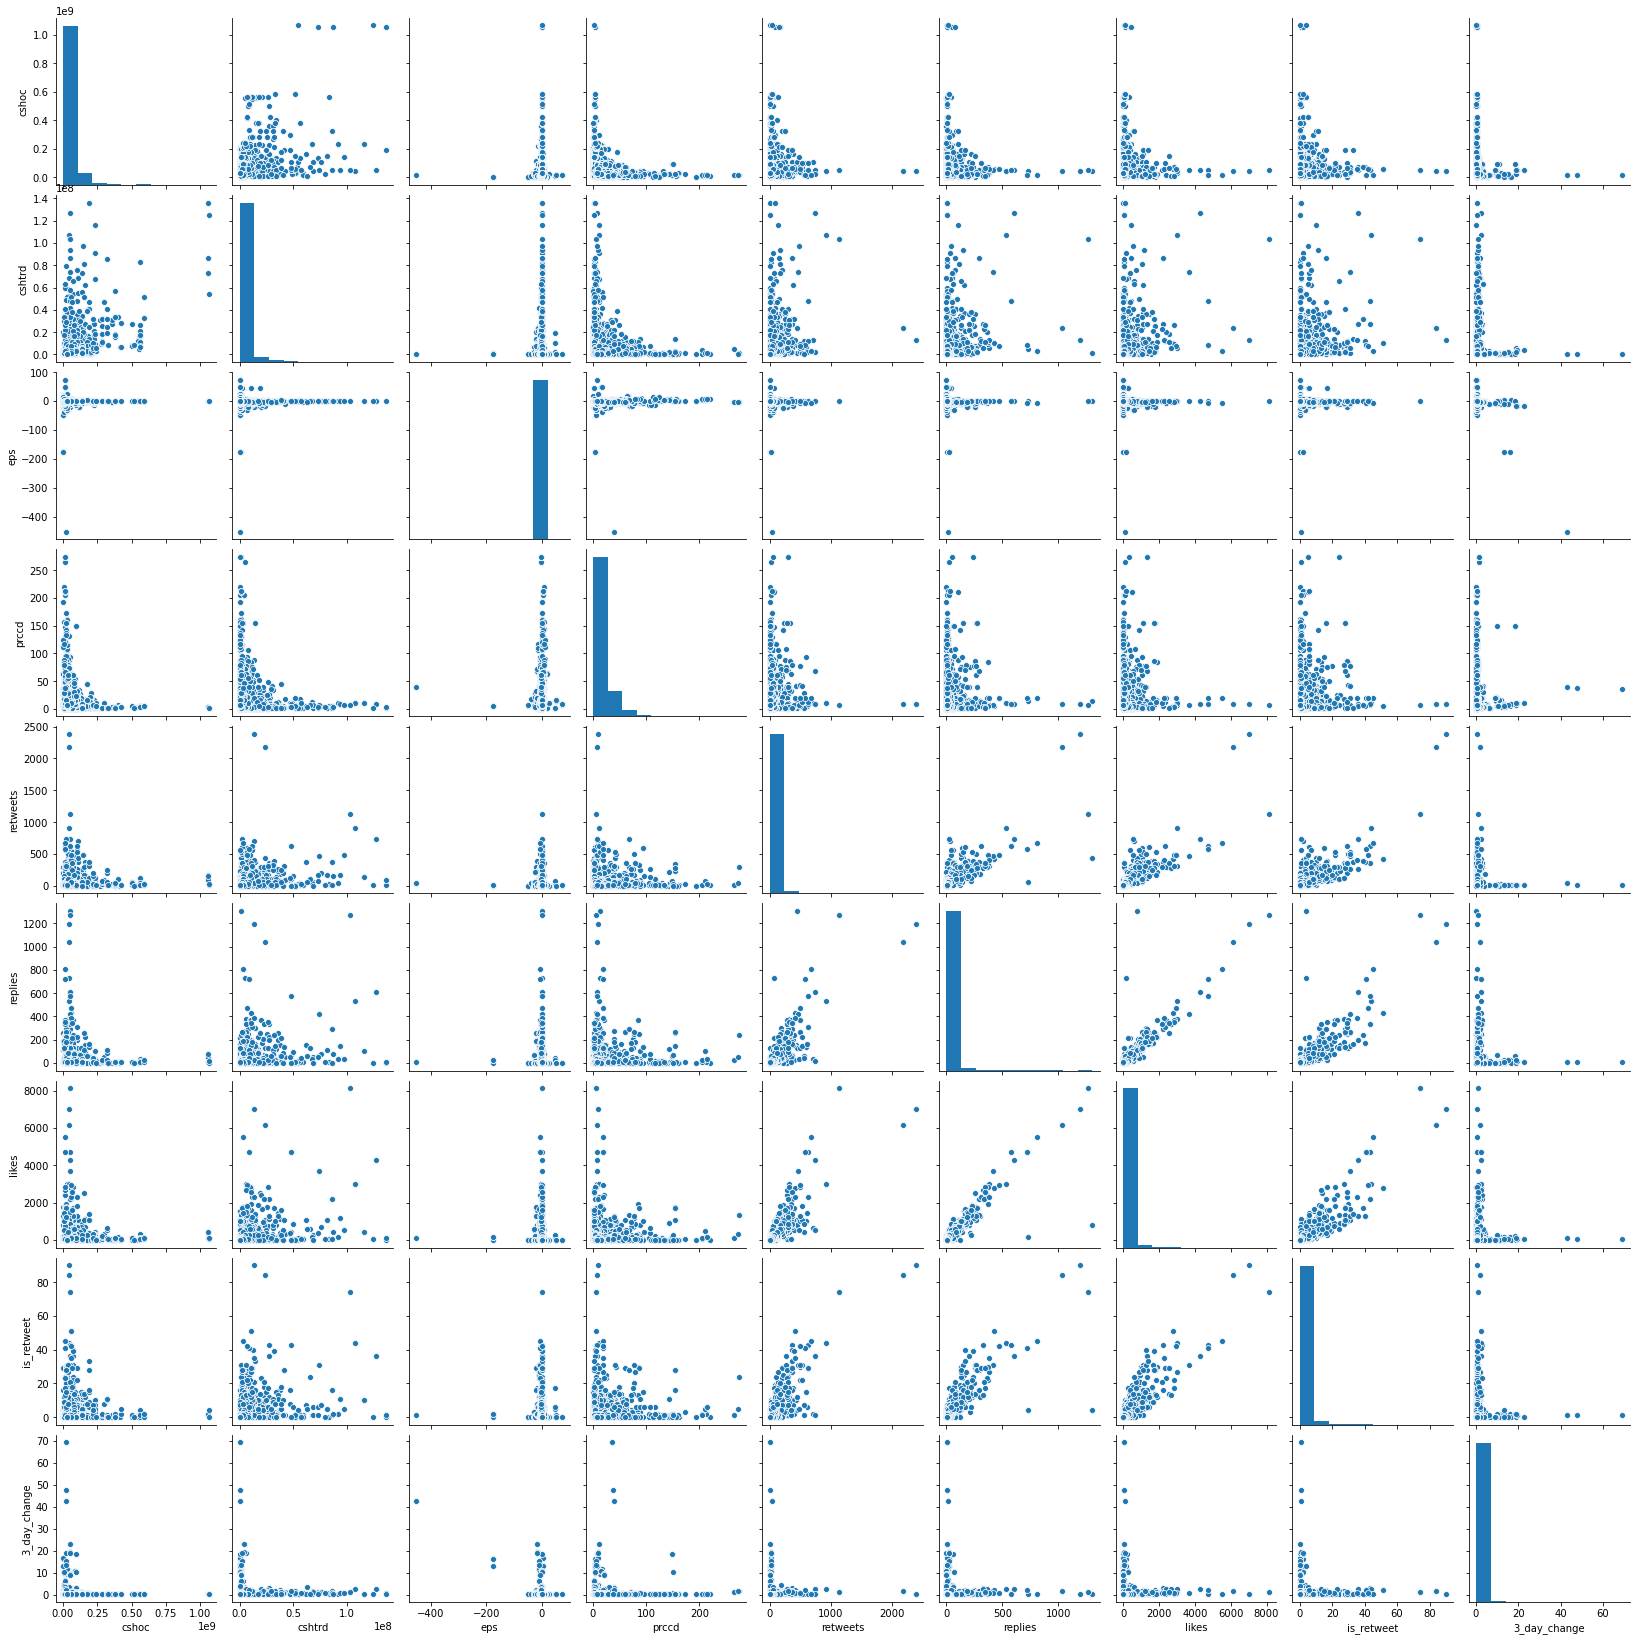

In [20]:
sns.pairplot(new_df2)

In [21]:
new_df2.head()

,datadate,tic,cshoc,cshtrd,eps,prccd,retweets,replies,likes,is_retweet,text,3_day_change
0,2017-01-12,AAOI,17198000.0,4413377.0,1.16,29.86,3.0,1.0,9.0,0.0,apply see q profit calculate day expect return...,0.342626
1,2017-01-13,AAOI,17198000.0,1532450.0,1.16,28.22,29.0,13.0,88.0,1.0,apply see q profit calculate day expect return...,0.233931
2,2017-01-17,AAOI,17198000.0,1412264.0,1.16,30.44,5.0,0.0,5.0,0.0,one favorite growth stock big future estimate ...,0.339789
3,2017-02-24,AAOI,17198000.0,6549167.0,1.82,45.98,12.0,2.0,74.0,0.0,new week high cc x apply inc set announce quar...,0.223849
4,2017-02-27,AAOI,17198000.0,1874979.0,1.82,47.46,34.0,18.0,124.0,4.0,apply impressive say tech trader daily apply i...,0.278556


In [22]:
new_df2.columns
import math

In [23]:
log_df = pd.DataFrame(columns = new_df.columns)
log_df = log_df.drop('eps',axis=1)
for column in log_df.columns:
    log_df[column] = new_df.loc[:,column].apply(lambda x: math.log(x+1))
log_df

TypeError: Addition/subtraction of integers and integer-arrays with Timestamp is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

In [ ]:
sns.pairplot(log_df)

In [ ]:
log_df2 = new_df[new_df.loc[:,'3_day_change']>math.log(1.2)].reset_index(drop=True)

In [ ]:
sns.pairplot(log_df2)

In [333]:
new_df['success'] = [int(i) for i in new_df.loc[:,'3_day_change']>0.2]

In [334]:
from sklearn.linear_model import LogisticRegression

In [335]:
new_df_rd = new_df.sample(frac = 1, random_state = 7012).reset_index(drop = True).drop(['3_day_change','prccd'],axis=1)

N_train = round(0.75*new_df_rd.shape[0])
x_train = new_df_rd.iloc[:N_train,:-1]
y_train = new_df_rd.iloc[:N_train,-1]
x_test = new_df_rd.iloc[N_train:,:-1]
y_test = new_df_rd.iloc[N_train:,-1]
x_total  = new_df_rd.iloc[:,:-1]
y_total = new_df_rd.iloc[:,-1]

In [336]:
model_lr = LogisticRegression(random_state = 7012)
model_lr.fit(x_total,y_total)

LogisticRegression(random_state=7012)

In [337]:
model_lr.predict(x_total)

array([0, 0, 0, ..., 0, 0, 0])

In [338]:
model_lr.score(x_total,y_total)

0.9458333333333333

In [339]:
total_one = 0
predict_one = 0
right_one = 0
for i in range(len(model_lr.predict(x_total))):
    if y_total.values[i]==1:
        total_one+=1
        if y_total.values[i]==model_lr.predict(x_total)[i]:
            right_one+=1
    if model_lr.predict(x_total)[i]==1:
        predict_one+=1

In [340]:
total_one

62

In [341]:
right_one

14

In [342]:
predict_one

31

<BarContainer object of 10 artists>

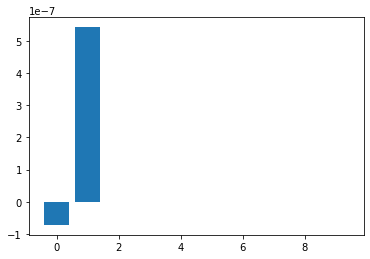

In [343]:
importance = model_lr.coef_[0]
plt.bar([x for x in range(len(importance))], importance)

In [344]:
new_df_rd = new_df.sample(frac = 1, random_state = 7012).reset_index(drop = True).drop(['3_day_change','prccd'],axis=1)

N_train = round(0.75*new_df_rd.shape[0])
x_train = new_df_rd.iloc[:N_train,-4:-1]
y_train = new_df_rd.iloc[:N_train,-1]
x_test = new_df_rd.iloc[N_train:,-4:-1]
y_test = new_df_rd.iloc[N_train:,-1]
x_total  = new_df_rd.iloc[:,-4:-1]
y_total = new_df_rd.iloc[:,-1]

In [345]:
model_lr = LogisticRegression(random_state = 7012)
model_lr.fit(x_total,y_total)

LogisticRegression(random_state=7012)

In [346]:
model_lr.predict(x_total)

array([0, 0, 0, ..., 0, 0, 0])

In [347]:
model_lr.score(x_total,y_total)

0.9483333333333334

In [348]:
total_one = 0
predict_one = 0
right_one = 0
for i in range(len(model_lr.predict(x_total))):
    if y_total.values[i]==1:
        total_one+=1
        if y_total.values[i]==model_lr.predict(x_total)[i]:
            right_one+=1
    if model_lr.predict(x_total)[i]==1:
        predict_one+=1

In [349]:
total_one

62

In [350]:
predict_one

0

In [351]:
right_one

0

In [352]:
data.shape

(903453, 12)

In [115]:
new_df = pd.concat([data,
                   npratio_df],axis = 1)

In [117]:
new_df.to_csv('sentiment_result.csv')

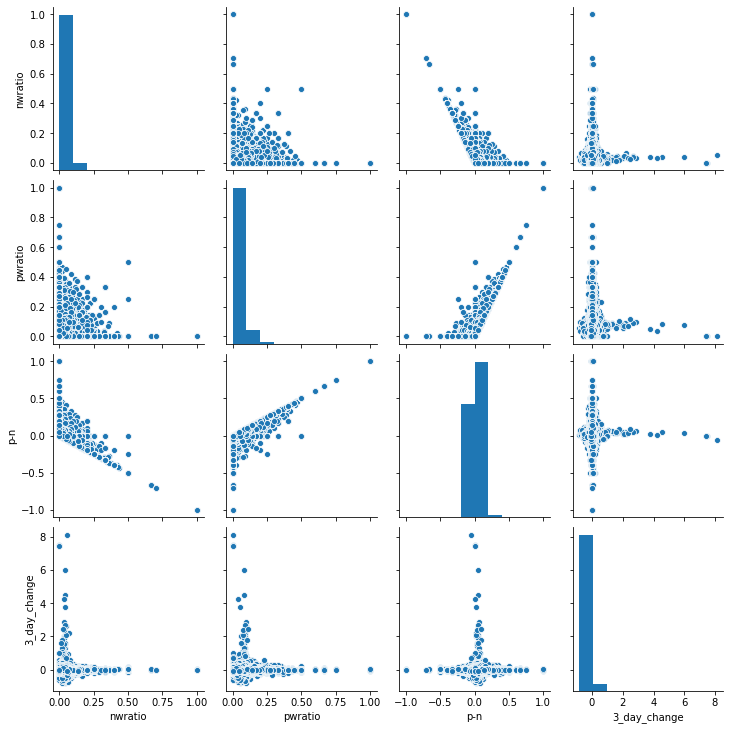

In [97]:
pp = sns.pairplot(final)
pp.savefig('pp.jpg')